In [1]:
!pip install nltk

In [2]:
%config Completer.use_jedi = False

In [91]:
import re
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import nltk
from nltk import wordpunct_tokenize, WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import gensim.downloader as api
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/imd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/imd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = pd.read_csv("train.csv")

In [6]:
df.head()

,name,review,game,platform,score,date,ID
0,GameSpy,Sporting some of the best writing and voice wo...,Portal 2,PC,100.0,"Apr 22, 2011",6
1,DarkZero,"In conclusion, Portal 2 is a textbook example ...",Portal 2,PC,100.0,"Apr 21, 2011",7
2,Destructoid,"Without a doubt, one of the best games ever ma...",Portal 2,PC,100.0,"Apr 21, 2011",9
3,GameWatcher,Never before has a review embargo had us screa...,Portal 2,PC,100.0,"Apr 19, 2011",11
4,VideoGamer,A mere ten minutes here will yield more memora...,Portal 2,PC,100.0,"Apr 19, 2011",13


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62175 entries, 0 to 62174
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      62175 non-null  object 
 1   review    62175 non-null  object 
 2   game      62175 non-null  object 
 3   platform  62175 non-null  object 
 4   score     62175 non-null  float64
 5   date      62151 non-null  object 
 6   ID        62175 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.3+ MB


In [8]:
df.describe()

,score,ID
count,62175.000000,62175.000000
mean,74.529136,62537.721721
std,14.479894,36353.332485
min,0.000000,6.000000
25%,70.000000,31031.500000
50%,80.000000,62230.000000
75%,85.000000,94068.000000
max,100.000000,125875.000000


In [9]:
df["date"] = pd.to_datetime(df["date"])

In [10]:
df.sort_values("date", ascending=True, inplace=True)

In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

In [12]:
COLS_TO_DROP = [
    "date", "ID"
]

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


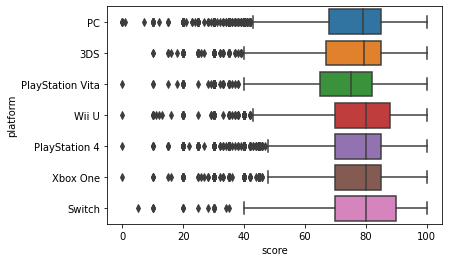

In [13]:
sns.boxplot(train_df["score"], train_df["platform"], orient="h");

In [15]:
COLS_TO_DROP.append("platform")

In [16]:
train_df.groupby("name")["date"].max()

name
1UP              2016-03-24
3DJuegos         2017-11-03
4Players.de      2017-10-27
Absolute Games   2012-11-29
ActionTrip       2016-06-20
                    ...    
XboxAddict       2017-10-30
Yahoo!           2017-10-26
YouGamers        2011-08-25
ZTGD             2017-10-25
games(TM)        2017-11-03
Name: date, Length: 265, dtype: datetime64[ns]

In [17]:
train_df.groupby("name")["date"].min()

name
1UP              2011-01-25
3DJuegos         2011-02-02
4Players.de      2012-02-01
Absolute Games   2010-12-23
ActionTrip       2011-03-17
                    ...    
XboxAddict       2016-07-13
Yahoo!           2015-11-18
YouGamers        2011-02-04
ZTGD             2011-02-22
games(TM)        2011-03-21
Name: date, Length: 265, dtype: datetime64[ns]

In [18]:
COLS_TO_DROP.append("name")

In [19]:
train_df.groupby("game")["date"].max()

game
#IDARB                        2015-03-30
.hack//G.U. Last Recode       2017-11-03
0RBITALIS                     2015-07-07
1-2-Switch                    2017-05-19
10 Second Ninja               2014-03-17
                                 ...    
htoL#NiQ: The Firefly Diary   2015-07-27
inFamous: First Light         2014-10-17
inFamous: Second Son          2014-05-16
inMomentum                    2012-02-27
theHunter: Call of the Wild   2017-05-22
Name: date, Length: 3226, dtype: datetime64[ns]

In [21]:
game_date_range = train_df.groupby("game")["date"].max() - train_df.groupby("game")["date"].min()

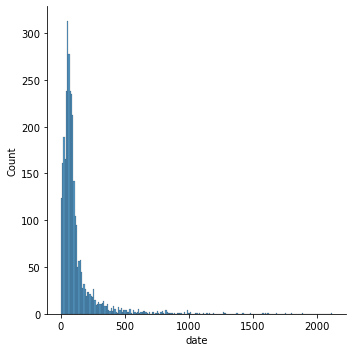

In [25]:
sns.displot(game_date_range.dt.days.sort_values(ascending=False));

In [26]:
COLS_TO_DROP.append("game")

In [27]:
COLS_TO_DROP

['date', 'ID', 'platform', 'name', 'game']

In [28]:
train_df.drop(columns=COLS_TO_DROP, inplace=True)
test_df.drop(columns=COLS_TO_DROP, inplace=True)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
train_df.head()

,review,score
1364,"Two Worlds is atmospheric and exiting, vast an...",70.0
1352,If you are looking for a really good role play...,91.0
1353,"Two Worlds 2 has lots of different quests, lot...",90.0
1356,Quotation forthcoming.,85.0
2596,"Still, Faery is commendable for being among th...",58.0


In [32]:
train_df["review"].sample().iloc[0]

'Whether playing a campaign against the computer or taking on eight other players in a random map, it bears the hallmark only a few empire building games have--the addiction to take "just one more turn".'

In [35]:
stem = SnowballStemmer("english")
lemma = WordNetLemmatizer()

In [55]:
stopwords_english = stopwords.words("english")

In [56]:
stopwords_english = set(stopwords_english)

In [57]:
stopwords_english.remove("not")

In [67]:
stopwords_english

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's'

In [58]:
IS_ALPHA = re.compile("[\w!?]+")


def preprocess(text):
    text = text.replace("&", " and ")
    text = text.replace("n't", " not ")
    text = text.lower()
    text_tokens = wordpunct_tokenize(text)
    text_tokens = [lemma.lemmatize(token) for token in text_tokens if IS_ALPHA.match(token)]
    text_tokens = [token for token in text_tokens if token not in stopwords_english]
    text = " ".join(text_tokens)
    return text.strip()

In [61]:
train_df["review_proceed"] = train_df["review"].apply(preprocess)
test_df["review_proceed"] = test_df["review"].apply(preprocess)

/tmp/ipykernel_13860/494565386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["review_proceed"] = train_df["review"].apply(preprocess)
/tmp/ipykernel_13860/494565386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["review_proceed"] = test_df["review"].apply(preprocess)


In [62]:
COLS_TO_FIT = "review_proceed"
TARGET_COL = "score"

In [72]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(token_pattern=r"\S+")),
    ("model", SGDRegressor(alpha=0)),
])

In [73]:
def train_and_validate(model, train_df, test_df):
    model.fit(train_df[COLS_TO_FIT], train_df[TARGET_COL])
    prediction = model.predict(test_df[COLS_TO_FIT])
    mse = mean_squared_error(test_df[TARGET_COL], prediction)
    print(f"mse: {mean_squared_error(test_df[TARGET_COL], prediction):.3f}")
    print(f"mae: {mean_absolute_error(test_df[TARGET_COL], prediction):.3f}")
    return mse

In [ ]:
train_and_validate(pipe, train_df, test_df)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


mse: 138.634
mae: 8.973


In [75]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(token_pattern=r"\S+", ngram_range=(1, 2))),
    ("model", SGDRegressor(alpha=0)),
])

In [76]:
train_and_validate(pipe, train_df, test_df)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


mse: 172.044
mae: 10.185


In [84]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(token_pattern=r"\S+", ngram_range=(1, 1), min_df=5, max_df=0.3)),
    ("model", SGDRegressor(alpha=0)),
])

In [85]:
train_and_validate(pipe, train_df, test_df)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


mse: 136.653
mae: 8.913


In [88]:
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(token_pattern=r"\S+", ngram_range=(1, 1), min_df=5, max_df=0.3)),
    ("model", SGDRegressor(alpha=0)),
])

In [89]:
train_and_validate(pipe, train_df, test_df)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


mse: 117.016
mae: 8.167


In [86]:
model = api.load("word2vec-google-news-300")

In [96]:
class Word2VecModel(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.model = model
        
    def get_mean_vector(self, text):
        v = np.zeros(300)
        c = 0
        for word in text.split(" "):
            if word in self.model:
                v += self.model.get_vector(word)
                c += 1
        c = max(1, c)
        return v / c
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([self.get_mean_vector(x) for x in X])

In [97]:
pipe = Pipeline([
    ("vectorizer", Word2VecModel(model)),
    ("model", SGDRegressor(alpha=0)),
])

In [98]:
train_and_validate(pipe, train_df, test_df)

mse: 134.995
mae: 8.797
